In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.1.dev320+g92a6eb9f4 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.maps import MapAxis
from gammapy.modeling.models.spectral import scale_plot_flux
from gammapy.estimators import  FluxPointsEstimator
    
from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

#sys.path.append(
#    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
#)
#from my_dataset_maps_20 import MapDatasetNuisance
#from MapDatasetNuisanceE import MapDatasetNuisanceE
#from  my_fit_20 import Fit
from Dataset_Creation import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : QQHILJ8J 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model ty

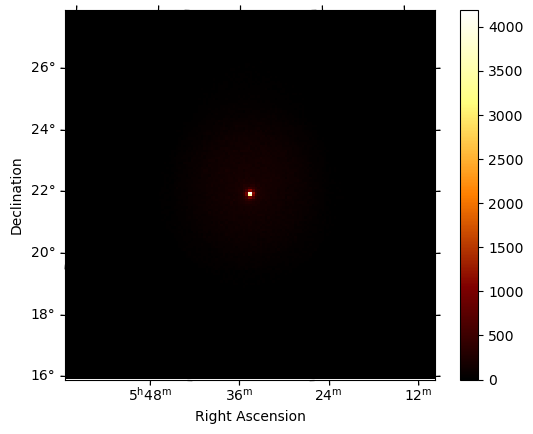

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_standard = dataset_standard.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models

dataset_asimov = dataset_standard.copy()
dataset_asimov.counts = dataset_standard.npred()
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_standard)

## Varying the Exposure

In [13]:
factor = +0.1
N = 24
sigma = 0.1
save = True
save_flux = True

In [14]:
for n in range(N):
    try:
        print(n)
        factor_rnd = np.random.normal(0, factor, 1)
        sys_d_cor = sys_dataset(dataset_asimov, factor_rnd, True)
        dataset = sys_d_cor.create_dataset()
        fit_cor = Fit(store_trace=False)
        result_cor = fit_cor.run([dataset])


        if save:
            with open("data/6a_P_draw_info.txt", "a") as myfile:
                myfile.write(str(float(factor_rnd)) + '    '+  str(float(dataset.stat_sum())) + '\n')

        stri = ""
        for p in ['amplitude', 'index', 'norm', 'tilt']:
            stri += str(dataset.models.parameters[p].value)  + '   ' +  str(dataset.models.parameters[p].error)  + '   '
        print(stri)
        if save:
            with open("data/6a_P_draw_par.txt", "a") as myfile:
                myfile.write(stri + '\n')


        mask = dataset.mask.data[:,60,60]

        ebins = dataset.counts.geom.axes[0].center[mask]
        fluxes = []
        for e in ebins:
            flux =  dataset.models[0].spectral_model(e)
            fluxes.append(flux.value)

        ff = str()
        for f in fluxes:
            ff += str(f) + "  "
        #print(ff)
        if save:
            with open("data/6a_P_draw_flux.txt", "a") as myfile:
                myfile.write( ff + '\n')


        energy_bounds = (ebins[0], ebins[-1] ) * u.TeV

        energy_min, energy_max = energy_bounds
        energy = MapAxis.from_energy_bounds(
            energy_min,
            energy_max,
            18,
        )

        fluxe2, _ = dataset.models[0].spectral_model._get_plot_flux(sed_type='dnde', energy=energy)
        fluxe2 = scale_plot_flux(fluxe2, energy_power=2)
        fluxe2 = fluxe2.quantity[:, 0, 0]
        fluxe2 = np.array(fluxe2)   
        ff = str()
        for f in fluxe2:
            ff += str(f) + "  "
        if save:
            with open("data/6a_P_draw_flux2e.txt", "a") as myfile:
                myfile.write( ff + '\n')

        energy_edges = dataset.geoms['geom'].axes[0].edges
        esti  = FluxPointsEstimator(energy_edges= energy_edges)
        fluxpoints = esti.run([dataset])
        if save_flux:
            fluxpoints.write(f'data/fluxpoints/6_fluxpoints_{factor_rnd[0]:.6}.fits')
    except:
        pass


0
1.0282399683666168e-12   8.851208669750176e-14   2.408190970767865   0.0662330780076045   0.9994775651924122   0.0020655890641727097   -0.00016780665754338752   0.0019614007321027372   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0496733664655409 0.9546023774579097
flux: len pen par: 0
norm 1.1792530557114804 0.36889290699864746
flux: len pen par: 0
norm 0.901355418012032 0.19183343121752633
flux: len pen par: 0
norm 1.0200625222464352 0.17129064051175966
flux: len pen par: 0
norm 0.9430238236134317 0.16981915657695737
flux: len pen par: 0
norm 0.9627428999553245 0.1843640404348671
flux: len pen par: 0
norm 1.2644233226114807 0.21072993081793107
flux: len pen par: 0
norm 0.834287958760167 0.21870552819247388
flux: len pen par: 0
norm 0.816372300872643 0.24445018938412236
flux: len pen par: 0
norm 1.104966948053408 0.2879500864512047
flux: len pen 

norm 1.006475511471707 0.20336736840215253
flux: len pen par: 0
norm 1.2935050746345462 0.18179861388073254
flux: len pen par: 0
norm 0.7501929046100696 0.17222873680525635
flux: len pen par: 0
norm 1.1312125499478625 0.18799268009665973
flux: len pen par: 0
norm 0.8227789243686271 0.18891616117879778
flux: len pen par: 0
norm 1.135386379519238 0.22481670996164246
flux: len pen par: 0
norm 0.5983315992036662 0.21420790620585978
flux: len pen par: 0
norm 0.8837005478250672 0.25626318202855003
flux: len pen par: 0
norm 0.8557604714124387 0.28146521537496916
flux: len pen par: 0
norm 0.6911565478558882 0.30871172492068194
flux: len pen par: 0
norm 0.653573481738313 0.3725052897693451
flux: len pen par: 0
norm 1.64945546247074 0.4960695858170009
flux: len pen par: 0
norm 0.9829752975360877 0.5140667584748811
flux: len pen par: 0
norm 0.8978069609162593 0.5113060021144178
flux: len pen par: 0
norm 1.6321235726918712 0.8278918410592176
flux: len pen par: 0
norm 3.8033249007406207 1.368931222

norm 0.36617891982748824 0.23562075485342246
flux: len pen par: 0
norm 0.6202661227232987 0.28252545045582445
flux: len pen par: 0
norm 1.3430050131133326 0.3829385201002608
flux: len pen par: 0
norm 1.6094584850326208 0.44373834296163533
flux: len pen par: 0
norm 0.8538292560411551 0.4377805956325549
flux: len pen par: 0
norm 1.556348560316922 0.6236606266335722
flux: len pen par: 0
norm 0.8013756660208767 0.555410081461766
flux: len pen par: 0
norm 1.873550656937562 0.8960846746538418
flux: len pen par: 0
norm 0.6603309355411959 0.6755923179429769
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
11
6.81161750675705e-13   7.391417922643357e-14   2.3274770150673842   0.07369584511248743   0.9983030127224288   0.0020637574356876733   8.439322368565244e-05   0.001962298203167504   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.9519061490908352 1.312

norm 1.292993338299903 0.7412418777553694
flux: len pen par: 0
norm 1.6921273420565983 0.9610711092799256
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
16
9.38403425926451e-13   8.315967086442775e-14   2.2731646311425786   0.05938451735430258   1.0006375462444452   0.0020667242632294762   -0.00032235827654714393   0.001960207154841298   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 2.0148043671295084 1.177880001330191
flux: len pen par: 0
norm 1.3896663987672353 0.42559016949035494
flux: len pen par: 0
norm 1.2071933444495735 0.2126428078098314
flux: len pen par: 0
norm 1.1099420073635857 0.17917149137209715
flux: len pen par: 0
norm 0.6545808542866314 0.16409877949644916
flux: len pen par: 0
norm 0.969169550399948 0.18105046633975125
flux: len pen par: 0
norm 0.6472761345848528 0.17924986179314353
flux: len pen par: 0
norm 1.0062503149324566 0.

flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.2094095148184663 1.2186582377928998
flux: len pen par: 0
norm 0.5395735544874228 0.4488742116578676
flux: len pen par: 0
norm 0.9517078180699077 0.23093265423500378
flux: len pen par: 0
norm 0.8456695118253594 0.1926078256073981
flux: len pen par: 0
norm 1.1684377727581914 0.1963218359220126
flux: len pen par: 0
norm 1.3195519170693075 0.2053370231807053
flux: len pen par: 0
norm 1.0832332350019738 0.20646354909682757
flux: len pen par: 0
norm 0.7028611071713793 0.20593579605413384
flux: len pen par: 0
norm 1.0568234902406677 0.2375954355243492
flux: len pen par: 0
norm 1.0117203169450348 0.24482424068614958
flux: len pen par: 0
norm 0.9276710666504482 0.2710658551586209
flux: len pen par: 0
norm 0.8676540147149713 0.2976492554941072
flux: len pen par: 0
norm 0.4797680807033101 0.2768200862730635
flux: len pen par: 0
norm 0.8159409130713628 0.3493351150387137
flux: len pen par: 0
norm 1.3117672351570668 0.4587559864511548
flux